# Análisis de las ventas de una tienda en línea de videojuegos por *Carlos Horta* (carlosgim@gmail.com)

---

## Introducción

**Ice** es una tienda en línea de venta de videojuegos a nivel mundial cuyo catálogo está compuesto por juegos de diferentes plataformas, tanto recientes como lanzados en años anteriores, y con diferentes clasificaciones de edad.

El **objetivo general** del proyecto es identificar patrones que determinen si un juego tiene éxito o no con la finalidad de buscar planificar las campañas publicitarias del siguiente año de la tienda en línea.

Los **objetivos específicos** son los siguientes:
- Analizar los datos recopilados hasta diciembre 2016 para identificar tendencias por plataformas y mercados.
- Crear perfiles de usuario para Norteamérica, la Unión Europea y Japón, quienes son los tres mercados más importantes en la industria de los juegos de video.
- Probar la hipótesis de que "las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas".
- Probar la hipótesis de que "las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes".

El **dataset** con el que se trabajará refleja las ventas del año 2016 y cuenta con las siguientes columnas:
- Name (Nombre)
- Platform (Plataforma)
- Year_of_Release (Año de lanzamiento)
- Genre (Género)
- NA_sales (ventas en Norteamérica en millones de dólares estadounidenses)
- EU_sales (ventas en Europa en millones de dólares estadounidenses)
- JP_sales (ventas en Japón en millones de dólares estadounidenses)
- Other_sales (ventas en otros países en millones de dólares estadounidenses)
- Critic_Score (máximo de 100)
- User_Score (máximo de 10)
- Clasificación (ESRB)


---

## Exploración de los datos

En esta primera parte del proyecto es necesario cargar las librerías a utilizar, así como el dataset, para luego realizar la preparación de los datos.

In [1]:
# Estas son las librerías a utilizar en el proyecto

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# Se carga el dataset de dos formas distintas

try:
    games = pd.read_csv("games.csv")
except:
    games = pd.read_csv("/datasets/games.csv")

In [3]:
# Estos son los datos del archivo 

games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Como se observa, existen 10 columnas en el dataset. La primera actividad será reemplazar los actuales nombres a minúsculas y el tipo de columna.

In [4]:
games.columns = ['name','platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']
games.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Una vez que se modificaron los nombres de las columnas, es necesario analizar cada una:

- **name**: Es necesario revisar si aparecen nombres repetidos o mal copiados. Además, se debe verificar la presencia de puntos finales y otros signos de puntuación que puedan estar de más. También es importante revisar si existen varias filas de un mismo juego que correspondan a diferentes plataformas.

- **platform**: Será importante revisar si existe uniformidad en los nombres de las consolas, ya sea en mayúsculas, minúsculas o combinaciones de ambos.

- **year_of_release**: Se debe cambiar el tipo de columna de números decimales a números enteros para reflejar adecuadamente el año de lanzamiento.

- **na_sales, eu_sales, jp_sales, other_sales**: Por lo que se observa, la información en decimales parece correcta. Sin embargo, es necesario revisar y rellenar con cero los valores ausentes, indicando que no se registraron ventas en esa región. Es común que algunos juegos solo estén disponibles en el mercado japonés y se prohíba su venta y distribución en otras regiones, y viceversa (aunque en menor medida).

- **critic_score, user_score, rating**: Se debe evaluar cómo manejar los valores ausentes (NaN). Podemos optar por reemplazarlos por cero o dejar las columnas como están actualmente. Además, es importante convertir la columna **user_score** a una de números decimales.

Importante, una vez que se termine de revisar columna por columna, el siguiente paso será trabajar con los valores ausentes de cada columna.


### Columna **name**

El primer paso es identificar las filas nulas que contienen nombres de videojuegos.

In [5]:
games[games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Como únicamente son dos los registros con datos nulos se eliminarán dichas entradas.

In [6]:
games = games.dropna(subset=['name'])
print(games[games['name'].isna()])

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []


Con respecto a la columna **name** será necesario identificar el número de entradas únicas, posteriormente se pasará toda la columna a minúsculas para revisar si existe alguna modificación en el número total de videojuegos enlistados.

In [7]:
games['name'].nunique()

11559

Como se observa en el resultado inmediato superior, hay un total de 11,559 videojuegos únicos en el dataset.

Posteriormente, se realizó una transformación a letras minúsculas de la columna 'name' con el fin de descubrir posibles discrepancias, pero no se encontraron diferencias significativas. Este paso no se menciona explícitamente en el proyecto, ya que no era posible revertir los nombres a su forma original (mayúsculas y minúsculas), por lo que solo se describe brevemente.

Decisión sobre la columna **name**: Se conserva tal como está, ya que el resultado es similar cuando se consulta el número de valores únicos en la columna tanto en su forma original como en minúsculas. Es posible encontrar juegos remasterizados, juegos con diferentes versiones (por ejemplo, "Batman Arkham Knight" y "Batman Arkham Knight: Game of the Year"), o el mismo juego para diferentes plataformas (por ejemplo, una entrada para "Batman Arkham Knight" en Xbox, "Batman Arkham Knight" en Playstation, etc.). Sin embargo, estas consideraciones no afectarán al proyecto, ya que el análisis se centrará en la plataforma, género y región.


### Columna **platform**

In [8]:
games['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Como se observa, existen 31 consolas únicas en la columna **Platform**, dichas columnas tienen los nombres de consolas de videojuegos populares en todo el mundo, y también existen consolas que únicamente se vendieron en ciertas regiones del mundo. 

Decisión sobre la columna **name**: todo parece correcto en la columna, por lo que únicamente se convertirán a minúscula el nombre de las consolas de videojuegos.

In [9]:
games['platform'] = games['platform'].str.lower()

---

### Columna **year of release**

Esta columna se convertirá en una de números enteros, posteriormente se tendrá que revisar el número de videojuegos que no tienen el año de lanzamiento en el dataset.

In [10]:
games = games.astype({'year_of_release' : 'Int64'})
print(games['year_of_release'].isnull().sum())
print('---------------')
print(games.isnull().mean()*100)

269
---------------
name                0.000000
platform            0.000000
year_of_release     1.609526
genre               0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.313349
user_score         40.082570
rating             40.471489
dtype: float64


In [11]:
# Estas son las 5 primeras filas del dataset

games.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,nes,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,gb,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Son 269 videojuegos los que no cuentan con la información del año de lanzamiento, lo cual representa el 1.6% de la totalidad de datos de la columna. No se pueden imputar con la media, la mediana u algún otro dato, ya que el año de lanzamiento es muy específico y dicha imputación no tendría mucha lógica en esta columna.

Hasta este momento, existen dos posibilidades: no imputar los valores y dejarlos en blanco, o bien, eliminarlos del dataset. Si se decide dejarlos en blanco, podrían aportar datos a la columna de ventas cuando se realicen perfiles por región. Sin embargo, al analizar los datos por año, no sería posible incluirlos en dicho ejercicio. Por lo tanto, la información que pueden aportar estos datos ausentes solo sería significativa para algunas variables específicas.

Decisión sobre la columna **year_of_release**: Los 269 videojuegos sin fecha de lanzamiento se dejarán en blanco debido a la información valiosa que se podría obtener del resto de las columnas.

---

### Columna **genre**

Como se comentó al inicio del proyecto, la columna **genre** tenía todos sus datos correctos, lo único pendiente es verificar ausentes (que probablemente ya no existan al eliminar las dos filas faltantes en **game**).

In [12]:
print(games[games['genre'].isna()])
print('-----------------')
print(games['genre'].describe())
print('-----------------')
print(games.info())

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []
-----------------
count      16713
unique        12
top       Action
freq        3369
Name: genre, dtype: object
-----------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: I

Como se observa, no hay datos erróneos o faltantes en la columna **genre**.

---

### Columna **na_sales**, **eu_sales**, **jp_sales**, **other_sales**

Las cuatro columnas con información de las ventas e Norteamérica, Europa, Japón y otros territorios al parecer no tienen datos faltantes, pero se revisarán para asegurar que así sea.

In [13]:
print(games['na_sales'].isnull().sum())
print(games['eu_sales'].isnull().sum())
print(games['jp_sales'].isnull().sum())
print(games['other_sales'].isnull().sum())
print('-----------------')
print(games.info())

0
0
0
0
-----------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB
None


Los datos se encuentran completos en estas cuatro columnas.

----

### Columna **critic_score**

Con respecto a la columna **critic_score** es necesario revisar sus filas ausentes para después decidir qué se realizará con esta.

In [14]:
print(games['critic_score'].isnull().sum())

8576


Existen 8,576 datos ausentes en esta columna. Toca revisar la dispersión de sus datos:

In [15]:
games['critic_score'].describe()

count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

Como se observa, la media y la mediana es cercana por lo que sus datos no se encuentran dispersos. 

Decisión sobre la columna **critic_score**: Los datos ausentes se dejarán tal y como están por la valía de la información de las otras columnas en esas filas.

------

### Columna **user_score**

Con respecto a la columna **user_score**, y al igual que en la de **critic_score**, se dejarán sin modificarlos debido a los datos valiosos que pueden aportar las otras columnas aun con filas faltantes de información sobre las calificaciones de los usuarios.
La única diferencia entre ambas columnas es que en **user_score** existen celdas con el texto TBD ("to be determined") por lo que se convertirán a *None* para evitar eliminar dichas filas por la valía de las información en las otras columnas.

In [16]:
games['user_score'] = games['user_score'].replace({'tbd' : np.nan})

In [17]:
games['user_score'].describe()

count     7590
unique      95
top        7.8
freq       324
Name: user_score, dtype: object

In [18]:
games['user_score'].head(5)

0      8
1    NaN
2    8.3
3      8
4    NaN
Name: user_score, dtype: object

---

### Columna **rating**

In [19]:
print(games.groupby('rating').size())
print('-----------')
print(games['rating'].describe())
print('-----------')
print(games['rating'].isnull().sum())

rating
AO         1
E       3990
E10+    1420
EC         8
K-A        3
M       1563
RP         3
T       2961
dtype: int64
-----------
count     9949
unique       8
top          E
freq      3990
Name: rating, dtype: object
-----------
6764


Como se observa en la columna **rating**, el dato que más se repite es la clasificación E (que significa apto para todo el público), así mismo, se observa que son 6,764 datos nulos (que equivale al 40% de la totalidad de los datos presentes y faltantes).

Decisión sobre la columna **rating**: Los datos ausentes se imputarán con la clasificación E, al ser esta la que más veces se encuentra en dicha columna.

In [20]:
games['rating'] = games['rating'].fillna('E')

---

### Nueva columna **all_regions_sales**

Por último, se creará una nueva columna a partir de sumar los datos de Norteamérica, Europa, Japón y otras regiones; la columna se denominará **all_regions_sales**.

In [21]:
games['all_regions_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
print(games.head(5))

                       name platform  year_of_release         genre  na_sales  \
0                Wii Sports      wii             2006        Sports     41.36   
1         Super Mario Bros.      nes             1985      Platform     29.08   
2            Mario Kart Wii      wii             2008        Racing     15.68   
3         Wii Sports Resort      wii             2009        Sports     15.61   
4  Pokemon Red/Pokemon Blue       gb             1996  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score user_score rating  \
0     28.96      3.77         8.45          76.0          8      E   
1      3.58      6.81         0.77           NaN        NaN      E   
2     12.76      3.79         3.29          82.0        8.3      E   
3     10.93      3.28         2.95          80.0          8      E   
4      8.89     10.22         1.00           NaN        NaN      E   

   all_regions_sales  
0              82.54  
1              40.24  
2              35.52  


---

### Sobre **valores ausentes**

In [22]:
games.isnull().sum()

name                    0
platform                0
year_of_release       269
genre                   0
na_sales                0
eu_sales                0
jp_sales                0
other_sales             0
critic_score         8576
user_score           9123
rating                  0
all_regions_sales       0
dtype: int64

Como se observa, los datos ausentes de **year_of_release**, **critic_score** y **user_score** se mantendrán con los datos faltantes y no se eliminarán debido a la información valiosa que contienen esas filas en el resto de las columnas.

### Otras consideraciones sobre las columnas

Por último, antes de cerrar esta apartado con el resumen de lo realizado por cada columna es necesario revisar que cada columna tenga el tipo de dato correcto.

In [23]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               16713 non-null  object 
 1   platform           16713 non-null  object 
 2   year_of_release    16444 non-null  Int64  
 3   genre              16713 non-null  object 
 4   na_sales           16713 non-null  float64
 5   eu_sales           16713 non-null  float64
 6   jp_sales           16713 non-null  float64
 7   other_sales        16713 non-null  float64
 8   critic_score       8137 non-null   float64
 9   user_score         7590 non-null   object 
 10  rating             16713 non-null  object 
 11  all_regions_sales  16713 non-null  float64
dtypes: Int64(1), float64(6), object(5)
memory usage: 1.7+ MB


In [24]:
games_none = games.copy()
games_none = games.replace({np.nan: None})

In [25]:
games_none.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               16713 non-null  object
 1   platform           16713 non-null  object
 2   year_of_release    16444 non-null  object
 3   genre              16713 non-null  object
 4   na_sales           16713 non-null  object
 5   eu_sales           16713 non-null  object
 6   jp_sales           16713 non-null  object
 7   other_sales        16713 non-null  object
 8   critic_score       8137 non-null   object
 9   user_score         7590 non-null   object
 10  rating             16713 non-null  object
 11  all_regions_sales  16713 non-null  object
dtypes: object(12)
memory usage: 1.7+ MB


---

### Resumen de la preparación de los datos por cada columna

Como paso inicial en la preparación de los datos, se revisaron los nombres de las columnas del dataset y se determinó convertirlos a minúsculas para facilitar el manejo de la información. A continuación, se detalla la preparación realizada columna por columna:

- **name**: Se encontraron 2 filas sin nombre de videojuegos, por lo que se decidió eliminar esas filas del dataset.

- **platform**: Se identificaron 31 consolas únicas en esta columna. Algunas consolas son locales y otras son de venta mundial, pero todos los datos estuvieron completos.

- **year_of_release**: Se convirtió el tipo de datos de float a string. Se revisó que había 269 videojuegos sin información de fecha de lanzamiento, lo cual representaba aproximadamente el 1.6% del total de datos en esa columna. Se decidió mantener esas 269 filas en lugar de eliminarlas debido a su valor de información para las otras columnas.

- **genre**: No se encontraron datos faltantes ni duplicados en esta columna.

- **na_sales**, **eu_sales**, **jp_sales**, **other_sales**: Las cuatro columnas no presentaban datos faltantes de ventas.

- **critic_score**: Los datos ausentes, incluyendo las filas vacías y aquellas con el texto "TBD" ("por determinar"), se mantuvieron sin cambios debido a su valor de información para las otras columnas.

- **user_score**: Los datos ausentes se dejaron sin modificar por su valor de información para las otras columnas.

- **rating**: Basándose en el valor modal de esta columna, los datos ausentes fueron imputados con la clasificación "E" ("apto para todo público"), que era el valor más frecuente.

- **all_region_sales**: Se creó una nueva columna a partir de las cuatro columnas existentes sobre ingresos regionales, la cual engloba las ventas mundiales de cada videojuego.

- Datasets **games** y **games_none**: El primero contiene los datos ausentes tal como están, mientras que el segundo dataset contiene los valores NaN cambiados por "None" para su uso en Plotly.

Este resumen refleja las acciones tomadas en la preparación de los datos en cada columna del dataset.


---


---

## Análisis de los datos

### Juegos lanzados por años

En este apartado se revisará el número de videojuegos lanzados por cada año, es importante tomar en cuenta que serán 36 *bins* que equivale al mismo número de años desde el primer juego lanzado al mercado en 1980 y hasta 2016 que es hasta donde abarca la información del dataset.

Median of year release: 2007.0
Median of year release: 2006.4862563853078


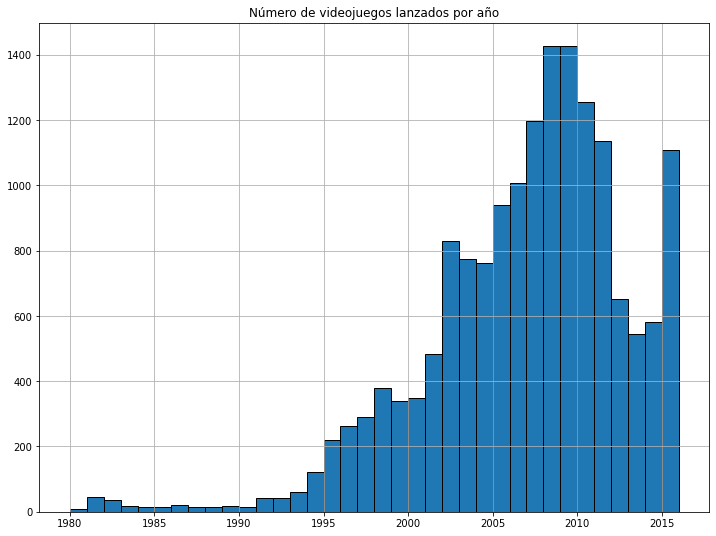

In [26]:
games.hist('year_of_release', bins=36, edgecolor='black', figsize=(12,9))
plt.title('Número de videojuegos lanzados por año')
print('Median of year release:', games.year_of_release.median())
print('Median of year release:', games.year_of_release.mean())

Como se observa, la media y la mediana son casi similares ya que la mediana de los datos es 2007 y la mediana es 2006.

El número de juegos lanzados por año se entiende a partir de pensarlo a partir del aumento anual del número de consolas, el número de videojuegos en el mercado y el número de usuarios, v.gr. en los años 80's apenas iniciaba la venta de consolas y videojuegos, a comparación de los lustros del 2005 y 2010 donde existía un mercado consolidado y el lanzamiento más frecuente de consolas de nueva generación (se estima que cada compañía lanza sus nuevas consolas cada seis años, en promedio).

### Ventas por plataforma

Como primer paso para analizar las ventas de una plataforma es necesario conocer las ventas totales y por tipo de plataforma.

In [27]:
ranking_platforms = games.groupby('platform')['all_regions_sales'].sum().sort_values(ascending=False)
print(ranking_platforms.head(5))

platform
ps2     1255.77
x360     971.42
ps3      939.65
wii      907.51
ds       806.12
Name: all_regions_sales, dtype: float64


Como se observa en el top de consolas más vendidas fueron:

- **PlayStation 2**: Lanzada el 24 de noviembre del año 2000, tiene el récord de ser la consola más vendida de la historia, con 155 millones de unidades vendidas, y la que cuenta con la mayor cantidad de títulos de videojuegos, alcanzando los 3,870.

- **Xbox 360**: Lanzado el 2 de diciembre de 2005 y continuó su producción hasta 2016, se estima que vendió 85.6 millones de unidades.

- **PlayStation 3**: Lanzado el 23 de marzo de 2007, con un estimado de 87.4 millones de consolas vendidas.

- **Nintendo Wii**: Comenzó a comercializarse el 8 de diciembre de 2006, con una venta estimada de casi 102 millones de consolas. Los últimos juegos lanzados para esta plataforma fueron en 2020.

- **Nintendo DS**: Lanzado el 21 de noviembre de 2004, es la segunda consola más vendida de la historia, superada únicamente por la PlayStation 2, con un total de casi 155 millones de unidades vendidas.

A partir de lo anterior, es posible darle mayor significado al top 5 de plataformas con más videojuegos vendidos hasta 2016. De las cinco consolas, cuatro son de mesa y una es portátil. Se encuentran dos consolas de Sony (PlayStation 2 y PlayStation 3), dos de Nintendo (Wii y DS), y una de Microsoft (Xbox 360). Es importante resaltar que tradicionalmente, el mercado más fuerte de Sony es el europeo y japonés, mientras que el de Microsoft es el americano, siendo Nintendo ampliamente vendido a nivel mundial.

Por otra parte, también es importante conocer las particularidades de las consolas con menos ventas en videojuegos:

In [28]:
print(ranking_platforms.tail(5))

platform
ws      1.42
tg16    0.16
3do     0.10
gg      0.04
pcfx    0.03
Name: all_regions_sales, dtype: float64


Las cinco consolas con menos videojuegos vendidos son:

- **PC-FX**: Fue lanzada el 23 de diciembre de 1994 y descontinuada en febrero de 1998. Solo logró vender 400,000 unidades, y la mayoría de ellas fueron en Japón.

- **Sega Game Gear**: Lanzada el 6 de octubre, esta consola estuvo en el mercado durante casi 7 años y se estima que vendió 10.6 millones de unidades portátiles.

- **3DO Interactive Multiplayer**: Lanzada en octubre de 1993, tuvo una duración de 4 años en el mercado y vendió 2 millones de unidades.

- **PC Engine TurboGrafx-16**: Se comercializó a partir de octubre de 1987 y vendió 10 millones de unidades.

- **Consola WonderSwan**: Lanzada en 1999 y descontinuada en 2003, logró vender 3.5 millones de unidades portátiles.

Como se observa con los datos de las consolas con menor cantidad de ventas, dichas consolas no lograron competir exitosamente contra los principales actores del mercado, como Nintendo, Sony y Sega, que dominaban la mayoría del mercado de las consolas en ese momento. Además, es importante destacar que estas consolas fueron lanzadas a finales de los años 80 y principios de los 90, cuando el mercado de los videojuegos estaba en pleno crecimiento y las diferentes compañías buscaban su lugar en la industria a nivel mundial.

Una vez analizadas las consolas más vendidas y menos vendidas, se realizará un distribución de las cinco consolas más vendidas para revisar su ventas año por año.

Antes de revisar las cinco consolas más vendidas es necesario convertir los NaN a None porque más adelante se utilizará la librería Plotly para ciertas gráficos y éstos podrían no desplegarse de manera correcta.

In [29]:
ps2_data_none = games_none.query('platform == "ps2"')
x360_data_none = games_none.query('platform == "x360"')
ps3_data_none = games_none.query('platform == "ps3"')
wii_data_none = games_none.query('platform == "wii"')
ds_data_none = games_none.query('platform == "ds"')

In [30]:
fig = px.histogram(ps2_data_none, x='year_of_release', y='all_regions_sales', title= 'Venta de videojuegos por año de la consola Play Station 2')
fig.update_layout(bargap=0.2)
fig.show()

In [31]:
fig = px.histogram(x360_data_none, x='year_of_release', y='all_regions_sales', title= 'Venta de videojuegos por año de la consola Xbox 360')
fig.update_layout(bargap=0.2)
fig.show()

In [32]:
fig = px.histogram(ps3_data_none, x='year_of_release', y='all_regions_sales', title= 'Venta de videojuegos por año de la consola Play Station 3')
fig.update_layout(bargap=0.2)
fig.show()

In [33]:
fig = px.histogram(wii_data_none, x='year_of_release', y='all_regions_sales', title= 'Venta de videojuegos por año de la consola Wii')
fig.update_layout(bargap=0.2)
fig.show()

In [34]:
fig = px.histogram(ds_data_none, x='year_of_release', y='all_regions_sales', title= 'Venta de videojuegos por año de la consola Nintendo DS')
fig.update_layout(bargap=0.2)
fig.show()

Como se puede observar, existe un dato erróneo en la información de la consola Nintendo DS ya que aparecen ventas del año 1985 cuando en realidad la consola fue lanzada en 2004.

En resumen, y aún con el dato erróneo de la consola Nintendo DS, es posible observar que las cinco consolas tuvieron ventas entre 2005 y 2014 únicamente, por lo que este dato nos sugiere que si se busca planear la campaña de mercadotecnia 2017 entonces es necesario elegir aquellas consolas con la mayor cantidad de ventas en 2016.

In [35]:
seis_data = games.query('year_of_release == 2016', engine='python')
seis_data.groupby('platform')['all_regions_sales'].sum().sort_values(ascending=False)

platform
ps4     69.25
xone    26.15
3ds     15.14
pc       5.25
wiiu     4.60
psv      4.25
ps3      3.60
x360     1.52
wii      0.18
Name: all_regions_sales, dtype: float64

Las 5 consolas con mayor cantidad de ventas de videojuegos lanzados en 2016 son la **Play Station 4**, el **Xbox One**, el Nintendo **3DS**, los juegos para **PC**, y el Nintendo **Wii U**.

Para el análisis de los datos, se tomará en cuenta una consola por empresa: de Sony la **Play Station 4**, de Microsoft el **Xbox One**, de Nintendo el **3DS** y aquellos juegos para **computadora**.

El siguiente paso es revisar cómo han sido las ventas por año de estas 4 consolas de videjuegos.

In [36]:
ps4_data_none = games_none.query('platform == "ps4"')
xone_data_none = games_none.query('platform == "xone"')
tresds_data_none = games_none.query('platform == "3ds"')
pc_data_none = games_none.query('platform == "pc"')

In [37]:
fig = px.histogram(ps4_data_none, x='year_of_release', y='all_regions_sales', title= 'Venta de videojuegos por año de la consola Play Station 4')
fig.update_layout(bargap=0.2)
fig.show()

In [38]:
fig = px.histogram(xone_data_none, x='year_of_release', y='all_regions_sales', title= 'Venta de videojuegos por año de la consola Xbox One')
fig.update_layout(bargap=0.2)
fig.show()

In [39]:
fig = px.histogram(tresds_data_none, x='year_of_release', y='all_regions_sales', title= 'Venta de videojuegos por año de la consola 3DS')
fig.update_layout(bargap=0.2)
fig.show()

In [40]:
fig = px.histogram(pc_data_none, x='year_of_release', y='all_regions_sales', title= 'Venta de videojuegos por año para PC')
fig.update_layout(bargap=0.2)
fig.show()

Como se puede observar en las gráficas de cada una de las cuatro plataformas, las ventas tienden en su mayoría a seguir una distribución normal. Esto significa que las ventas aumentan progresivamente cada año y luego disminuyen. Sin embargo, es importante tener en cuenta que las ventas mostradas en los gráficos corresponden al año de lanzamiento de los videojuegos, lo cual introduce un sesgo. Por ejemplo, si en el año 2016 se lanzaron solo cinco videojuegos para la Play Station 4, la suma de las ventas de ese año solo reflejará las ventas de esos cinco videojuegos a nivel mundial, sin tener en cuenta las ventas de los juegos lanzados en años anteriores.

Además, se comprende que cada generación de consolas se lanza aproximadamente cada seis años. Por lo tanto, para un análisis más preciso de las ventas globales, sería adecuado seleccionar las consolas más recientes, como la Play Station 4, el Xbox One, el Nintendo 3DS y los juegos para PC. Estas plataformas representan la última generación de consolas disponibles al momento del análisis y ofrecen una perspectiva más actualizada de las ventas en el mercado.

---

## Plataformas de videojuegos más rentables

Para conocer las ventas globales de todos los videojuegos por cada una de las cuatro plataformas seleccionadas será necesario revisar un diagrama de caja para visualizar los datos normales dentro de la distribución y los extremos.

In [41]:
top_profit = games_none.query('platform == "ps4"| platform == "xone" | platform == "3ds" | platform == "pc"')
fig =px.box(top_profit, x='platform', y='all_regions_sales', color='platform', points='all', title='Ventas mundiales por consola de videojuegos')
fig.update_traces(quartilemethod='exclusive')
fig.show()

Como se puede observar en el boxplot anterior, los datos muestran similitudes en las cajas y las medianas entre el Play Station 4 y el Xbox One, aunque el Play Station 4 presenta una mayor cantidad de datos extremos superiores. Además, el Nintendo 3DS también muestra algunos datos extremos superiores similares a los del Play Station 4.

En resumen, el Play Station 4 y el Xbox One son plataformas de referencia actual (para 2016 y 2017) para que los desarrolladores de videojuegos los tengan en cuenta en el lanzamiento de sus próximos títulos. Aunque en algunos casos existen licencias exclusivas, como el juego "The Last of Us" exclusivo para Play Station y "Halo" exclusivo para Xbox, en la mayoría de los casos el lanzamiento de nuevos videojuegos es multiplataforma. Esto significa que los desarrolladores tienden a lanzar juegos para diversas plataformas, aprovechando la amplia disponibilidad de las consolas más populares.

---

### Reseñas de usuarios y de críticos profesionales

El siguiente apartado del proyecto es revisar si las reseñas de usuarios y de críticos profesionales afectan las ventas de una plataforma. Para este caso, se utilizará un gráfico de dispersión y se calculará la correlación entre las reseñas y las ventas tanto del Play Station 4 como del Xbox One.

In [42]:
ps4_xboxone_none = games_none.query('platform == "ps4"| platform == "xone"')
fig = px.scatter(ps4_xboxone_none, x='critic_score', y='all_regions_sales', color='platform', title='Ventas mundiales y críticas profesionales para Play Station 4 y Xbox One',trendline='ols')
fig.show()

Como se puede observar con el gráfico de dispersión de ventas mundiales y críticas profesionales existe una ligera correlación positiva entre ambas. También se puede observar que los puntos azules que representan el Play Station 4 aparecen más dispersos de la línea de tendencia que los del Xbox One.

In [43]:
fig = px.scatter(ps4_xboxone_none, x='user_score', y='all_regions_sales', color='platform', title='Ventas mundiales y críticas de usuarios para Play Station 4 y Xbox One',trendline='ols')
fig.show()

Al contrario que el gráfico anterior, existe una ligera correlación negativa entre las ventas a nivel mundial y las críticas de usuarios de ambas consolas. Aquí también puede observarse que los puntos azules del Play Station 4 se encuentran más dispersos de la línea de tendencia a comparación de los puntos rojos que representan el Xbox One.

C:\Users\carlo\AppData\Local\Temp\ipykernel_41516\1811390069.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



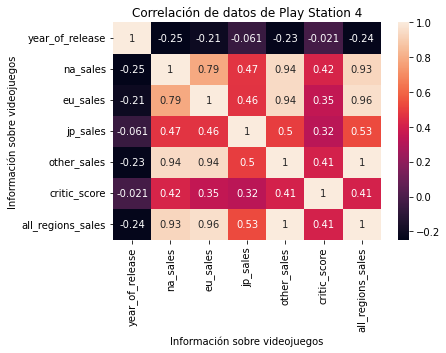

In [44]:
ps4_data= games.query('platform == "ps4"')
correlation_matrix=ps4_data.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlación de datos de Play Station 4')
plt.xlabel('Información sobre videojuegos')
plt.ylabel('Información sobre videojuegos')
plt.show()

C:\Users\carlo\AppData\Local\Temp\ipykernel_41516\3715808820.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



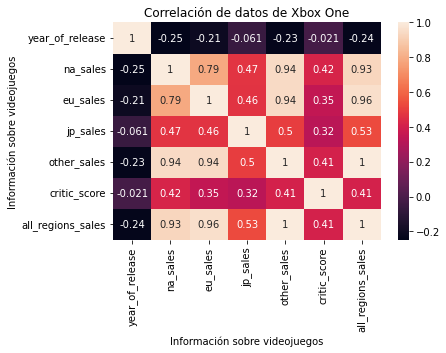

In [45]:
xone_data=games.query('platform == "ps4"')
correlation_matrix=xone_data.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlación de datos de Xbox One')
plt.xlabel('Información sobre videojuegos')
plt.ylabel('Información sobre videojuegos')
plt.show()

Por último, al observar el mapa de calor, se puede notar que existe una correlación positiva débil entre las críticas profesionales y las ventas mundiales, así como con las ventas de las cuatro regiones incluidas en el dataset.

En contraste, el mismo mapa muestra una correlación negativa débil entre las críticas de los usuarios y las ventas mundiales totales, así como con las ventas de las cuatro regiones.

Esto indica que las críticas profesionales tienen una leve influencia positiva en las ventas de videojuegos a nivel mundial y en las diferentes regiones. Por otro lado, las críticas de los usuarios muestran una leve tendencia negativa, lo que sugiere que una mayor calificación de los usuarios no necesariamente se traduce en mayores ventas.

Es importante tener en cuenta que estas correlaciones son débiles y otros factores pueden influir significativamente en las ventas de videojuegos, como la popularidad de la franquicia, la estrategia de marketing y la disponibilidad en diferentes plataformas.

---


### Venta de juegos multiplataformas

Es común, que una importante mayoría de videojuegos tengan un lanzamiento mundial y que este también sea multiplataforma al mismo tiempo, en ciertas ocasiones algunos desarrolladores prefieren lanzar sus videojuegos en las plataformas principales de cada compañía y posteriormente (entre dos y tres meses) lanzar al mercado la versión en otras plataformas.

En este apartado, se evaluarán las ventas de los juegos multiplataformas que tuvieron lanzamiento tanto en Playstation 4 como en el Xbox One.

In [46]:
ps4_xboxone = games.query('platform == "ps4"| platform == "xone"')
duplicate_titles = ps4_xboxone[ps4_xboxone.duplicated(subset='name', keep=False)]
duplicate_titles.sort_values('name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_regions_sales
9197,7 Days to Die,ps4,2016,Action,0.04,0.08,0.00,0.02,45.0,5.9,M,0.14
12863,7 Days to Die,xone,2016,Action,0.03,0.02,0.00,0.00,35.0,5.2,M,0.05
12920,Adventure Time: Finn & Jake Investigations,xone,2015,Action,0.03,0.02,0.00,0.00,NaN,NaN,E,0.05
10893,Adventure Time: Finn & Jake Investigations,ps4,2015,Action,0.03,0.05,0.00,0.02,NaN,NaN,E,0.10
14940,Agatha Christie's The ABC Murders,ps4,2016,Adventure,0.01,0.01,0.00,0.00,67.0,6.2,T,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...
9117,XCOM 2,ps4,2016,Strategy,0.04,0.08,0.00,0.02,88.0,8,T,0.14
16645,ZombiU,xone,2016,Action,0.00,0.01,0.00,0.00,NaN,NaN,E,0.01
12761,ZombiU,ps4,2016,Action,0.00,0.04,0.01,0.01,NaN,NaN,E,0.06
7539,Zombie Army Trilogy,ps4,2015,Shooter,0.05,0.12,0.00,0.03,62.0,6.8,E,0.20


In [47]:
duplicate_titles_sales = duplicate_titles.pivot_table(index='name', columns='platform', values='all_regions_sales')
duplicate_titles_sales.head(20)

platform,ps4,xone
name,,
7 Days to Die,0.14,0.05
Adventure Time: Finn & Jake Investigations,0.10,0.05
Agatha Christie's The ABC Murders,0.02,0.01
Alien: Isolation,1.12,0.50
Angry Birds Star Wars,0.22,0.17
Arslan: The Warriors of Legend,0.09,0.01
Assassin's Creed Chronicles,0.08,0.01
Assassin's Creed IV: Black Flag,2.86,2.24
Assassin's Creed Syndicate,3.39,1.29


Como se puede observar, en cada título analizado, las ventas en el Play Station 4 fueron superiores en comparación con el Xbox One. Solo en pocos títulos se encontraron ventas similares entre ambas plataformas.

Es importante tener en cuenta que el número de consolas vendidas del Play Station 4 es aproximadamente el doble que el del Xbox One. Por lo tanto, es comprensible que haya una proporción mayor de ventas mundiales a favor de los videojuegos para la consola de Sony, debido a la mayor base instalada de consolas Play Station 4 en comparación con el Xbox One. Esta diferencia en la base de usuarios puede influir en las ventas de los videojuegos y explicar la superioridad en las ventas del Play Station 4 en la mayoría de los casos analizados.

--------

### Géneros de videojuegos más rentables

Con respecto a los géneros de videojuegos más vendidas es importante recordar que existe 12 diferentes. 

Es necesario revisar el total de ventas mundiales para todos los géneros para determinar los cinco primeros y los cinco últimos.

In [48]:
genre_games_grouped = games.groupby('genre', sort=False).sum()
sorted_genre_games_grouped = genre_games_grouped.sort_values('all_regions_sales', ascending=False)

C:\Users\carlo\AppData\Local\Temp\ipykernel_41516\3475596163.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [49]:
fig = px.histogram(games, x='genre', y='all_regions_sales', title= 'Ventas mundiales de videojuegos por género')
fig.update_layout(bargap=0.2)
fig.show()

In [50]:
fig = px.box(games_none, x="genre", y="all_regions_sales", color="genre", title='Ventas mundiales por género de videojuegos')
fig.update_traces(quartilemethod="exclusive")
fig.show()

Como se observa en la tabla superior, en el histograma y en el box plot, los videojuegos de **acción**, **deportes**, **disparos**, **de rol** y de **plataformas** fueron los géneros más vendidos a nivel mundial al sumar la totalidad de la base de datos.

## Perfil de usuario para las región de Norteamérica, Europa y Japón

En este apartado del proyecto se busca determinar para cada una de las tres regiones las cinco **plataformas** principales, los cinco **géneros** de videojuegos principales y si las **clasificaciones** de ESRB (Entertainment Software Rating Board) afectan a las ventas en regiones individuales.

### Norteamérica

In [51]:
columns = ['platform', 'genre', 'rating']

for column in columns:
    north_america = games_none.groupby(column)['na_sales'].sum().sort_values(ascending=False)
    
    print(north_america.head())
    fig = px.bar(north_america)
    fig.show()

platform
x360    602.47
ps2     583.84
wii      496.9
ps3     393.49
ds       382.4
Name: na_sales, dtype: object


genre
Action      879.01
Sports      684.43
Shooter     592.24
Platform     445.5
Misc        407.27
Name: na_sales, dtype: object


rating
E       2533.67
T        759.75
M        748.48
E10+     353.32
K-A        2.56
Name: na_sales, dtype: object


En Norteamérica, el top 5 de ventas de videojuegos por plataforma está encabezado por el Xbox 360 de Microsoft, seguido por el Play Station 2, el Nintendo Wii, el Play Station 3 y el Nintendo DS. De estos, cuatro son consolas de mesa y una es una consola portátil (Nintendo DS).

En cuanto a los géneros de videojuegos con mayores ventas, se destacan los juegos de acción, deportes, disparos, plataforma y misceláneos. La categoría de misceláneos incluye aquellos videojuegos que tienen una categoría diferente o no obvia en comparación con los demás géneros.

En cuanto a las clasificaciones de los videojuegos más vendidos, se encuentran las siguientes categorías: Everyone (para todos), Teen (para mayores de 13 años), Mature (para mayores de 17 años), E10+ (para mayores de 10 años) y K-A (para niños y hasta adultos). Es importante destacar que K-A corresponde a un sistema antiguo de clasificación y equivale a la clasificación E (para todos) en el sistema actual de clasificación de videojuegos.

### Europa

In [52]:
columns = ['platform', 'genre', 'rating']

for column in columns:
    north_america = games_none.groupby(column)['eu_sales'].sum().sort_values(ascending=False)
    
    print(north_america.head())
    fig = px.bar(north_america)
    fig.show()

platform
ps2     339.29
ps3     330.29
x360    270.76
wii     262.21
ps      213.61
Name: eu_sales, dtype: object


genre
Action     519.13
Sports     376.79
Shooter    317.34
Racing     236.51
Misc       212.74
Name: eu_sales, dtype: object


rating
E       1323.55
M        483.97
T        427.03
E10+     188.52
AO         0.61
Name: eu_sales, dtype: object


Para el territorio europeo, las mayores ventas de videojuegos corresponden al Play Station 1, 3 y 4, al Xbox 360 y al Nintendo Wii. Todas estas plataformas son consolas de mesa.

En cuanto a los géneros de videojuegos con mayores ventas, se destacan los de acción, deportes, disparos, carreras y misceláneos. Estos géneros son populares entre los jugadores europeos.

En relación a las clasificaciones de los videojuegos más vendidos, se encuentran las siguientes categorías: Everyone (para todos), Mature (para mayores de 17 años), Teen (para mayores de 13 años), E10+ (para mayores de 10 años) y Solo para Adultos (AO). Estas clasificaciones indican el público objetivo al que van dirigidos los juegos y reflejan las preferencias de los jugadores europeos en cuanto a contenido y edad apropiada.

---

### Japón

In [53]:
columns = ['platform', 'genre', 'rating']

for column in columns:
    north_america = games_none.groupby(column)['jp_sales'].sum().sort_values(ascending=False)
    
    print(north_america.head())
    fig = px.bar(north_america)
    fig.show()

platform
ds      175.57
ps      139.82
ps2      139.2
snes    116.55
3ds     100.67
Name: jp_sales, dtype: object


genre
Role-Playing    355.41
Action          161.43
Sports          135.54
Platform        130.83
Misc            108.11
Name: jp_sales, dtype: object


rating
E       1040.04
T         151.4
M         64.24
E10+       40.2
K-A        1.46
Name: jp_sales, dtype: object


Las preferencias en Japón son más particulares en comparación con los mercados de América del Norte y Europa. En el país nipón, los videojuegos más vendidos corresponden al Nintendo DS, al PlayStation 1 y 2, al Super Nintendo y al Nintendo 3DS. De estos cinco, dos son consolas portátiles y tres son de mesa. Además, en términos de fabricantes, tres pertenecen a Nintendo y dos a Sony, ambas empresas japonesas.

En cuanto a los géneros de los videojuegos más vendidos, se destacan los juegos de roles, acción, deportes, plataformas y misceláneos. Estos géneros reflejan las preferencias de los jugadores japoneses.

En relación a las clasificaciones de los videojuegos más frecuentes, se encuentran las siguientes categorías: Everyone (para todos), Teen (para mayores de 13 años), Mature (para mayores de 17 años), E-10 (para mayores de 10 años) y K-A (del antiguo sistema de clasificación que equivale a la categoría Everyone). Estas clasificaciones indican la edad recomendada para cada tipo de juego y reflejan las pautas culturales y las preferencias de los jugadores japoneses en cuanto a contenido y temáticas apropiadas.

#### Conclusiones del perfil de usuario para cada región

Aquí están las conclusiones del perfil de usuario para cada región:

- Los usuarios de Norteamérica y Europa comparten un perfil global más similar en comparación con los usuarios de Japón.

- La consola Xbox 360 de Microsoft, de origen estadounidense, es la más vendida en Norteamérica, la tercera en Europa, pero ocupa el decimoctavo lugar en Japón.

- En Japón, los videojuegos de roles son los más vendidos, mientras que en Norteamérica y Europa ocupan el séptimo puesto.

- En cuanto a las consolas portátiles, en Japón ocupan el primer y quinto lugar entre los videojuegos más vendidos, en Norteamérica el quinto lugar y en Europa el sexto lugar.

- En relación a las clasificaciones de la ESRB, no hay una gran diversidad entre los tres perfiles de región. En todas las regiones, los videojuegos con clasificación "Everyone" (para todos los públicos) son los más vendidos, seguidos por los juegos para mayores de 13 años (Teen), mayores de 17 años (Mature) y mayores de 10 años (E10+).

Estas conclusiones resaltan las diferencias y similitudes en los perfiles de usuarios de cada región, lo cual es importante tener en cuenta al planificar campañas publicitarias y desarrollar nuevos videojuegos para cada mercado específico

---

## Pruebas de hipótesis

En este apartado se realizarán pruebas de hipótesis sobre el dataset de ventas de videojuegos, con el objetivo de analizar las siguientes afirmaciones:

- Hipótesis 1: Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.
Para probar esta hipótesis, se utilizará una prueba de hipótesis de comparación de medias. Se compararán las calificaciones promedio de los usuarios para ambas plataformas utilizando un nivel de significancia del 0.05.

- Hipótesis 2 : Las calificaciones promedio de los usuarios para los géneros de Acción y Deporte son diferentes.
Para probar esta hipótesis, también se utilizará una prueba de hipótesis de comparación de medias. Se compararán las calificaciones promedio de los usuarios para los géneros de Acción y Deporte utilizando un nivel de significancia del 0.05.

En ambos casos, se analizará si hay evidencia suficiente para rechazar la hipótesis nula y concluir que hay diferencias significativas entre las calificaciones promedio.

Es importante destacar que el análisis se realizará utilizando las calificaciones promedio de los usuarios en el dataset de ventas de videojuegos.

### Prueba de hipótesis #1

**Hipótesis nula**: *Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.*

**Hipótesis alternativa**: *Las calificaciones promedio de los usuarios para loas plataformas Xbox One y PC son diferentes.*

In [54]:
games_drop_na = games.dropna()
games_drop_na.user_score = games_drop_na.user_score.astype(float)

xone_data_drop_na = games_drop_na.query('platform == "xone"')
pc_data_drop_na = games_drop_na.query('platform == "pc"')

C:\Users\carlo\AppData\Local\Temp\ipykernel_41516\1299868638.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
xone_data_drop_na_userscore = xone_data_drop_na['user_score']
pc_data_drop_na_userscore = pc_data_drop_na['user_score']

alpha = 0.05

result_test = st.ttest_ind(xone_data_drop_na_userscore, pc_data_drop_na_userscore)
print('p-value:', result_test.pvalue)

if result_test.pvalue < alpha:
    print('Rechazamos la hipótesis nula')
else:
    print('No rechazamos la hipótesis nula')


p-value: 0.00010211482734739939
Rechazamos la hipótesis nula


De acuerdo al test de verificación de hipótesis, se puede determinar que existe evidencia estadísticamente significativa sobre que las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes.

### Prueba de hipótesis #2

**Hipótesis nula**: *Las calificaciones promedio de los usuarios para los géneros de Acción y Deporte son las mismas.*

**Hipótesis alternativa**: *Las calificaciones promedio de los usuarios para los géneros de Acción y Deporte son diferentes.*

In [56]:
genre_action_drop_na = games_drop_na.query('genre == "Action"')
genre_sports_drop_na = games_drop_na.query('genre == "Sports"')

In [57]:
genre_action_drop_na_userscore = genre_action_drop_na['user_score']
genre_sports_drop_na_userscore = genre_sports_drop_na['user_score']

alpha = 0.05

result_test = st.ttest_ind(genre_action_drop_na_userscore, genre_sports_drop_na_userscore)
print('p-value:', result_test.pvalue)

if result_test.pvalue < alpha:
    print('Rechazamos la hipótesis nula')
else:
    print('No rechazamos la hipótesis nula')

p-value: 0.9785200320585197
No rechazamos la hipótesis nula


De acuerdo al test de verificación de hipótesis, se puede determinar que existe evidencia estadísticamente significativa sobre que la calificaciones promedio de los usuarios para los género de Acción y Deporte son similares.

---

## Conclusión general

### Análisis de las ventas de una tienda en línea de videojuegos

El objetivo de este proyecto fue identificar patrones que determinen el éxito de los videojuegos con el fin de planificar las campañas publicitarias del próximo año de la tienda en línea. Se plantearon cuatro objetivos específicos:

1. Analizar los datos recopilados hasta diciembre de 2016 para identificar tendencias por plataformas y mercados.
2. Crear perfiles de usuario para Norteamérica, la Unión Europea y Japón.
3. Probar la hipótesis de que las calificaciones promedio de los usuarios de las plataformas Xbox One y PC son las mismas.
4. Probar la hipótesis de que las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

El proyecto comenzó con la preparación de los datos, la revisión columna por columna y la creación de una nueva columna que engloba las ventas mundiales de cada videojuego.

Posteriormente, se realizó un análisis detallado de los juegos lanzados por año, las ventas por plataforma, las plataformas más rentables, el impacto de las reseñas de los usuarios y los críticos profesionales en las ventas de videojuegos, la venta de videojuegos multiplataforma y los géneros más rentables.

A continuación, se crearon perfiles de usuario para las regiones de Norteamérica, Europa y Japón, lo que permitió una comprensión más profunda de las preferencias y comportamientos de los jugadores en cada región.

Finalmente, se llevaron a cabo pruebas de hipótesis para determinar si los promedios de calificaciones de los usuarios en las plataformas Xbox One y PC son similares, y si las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

En conclusión, el departamento de Marketing debe centrar su atención en las consolas de videojuegos más recientes en el mercado, como el Play Station 4, Xbox One, Nintendo Wii U y PC. Estas consolas tendrán lanzamientos de videojuegos asegurados durante varios años. También es importante aprovechar las campañas de marketing de las empresas Sony, Microsoft, Nintendo y otros desarrolladores, ya que la tienda ICE puede beneficiarse al asociarse con estos lanzamientos.

Además, se debe prestar atención a las opiniones de los críticos profesionales, ya que aunque tienen una correlación positiva mínima, es posible destacar aquellas críticas que sean relevantes para el público de ICE.

El departamento de marketing también puede enfocarse en promover videojuegos de los géneros de Acción, Deportes, Disparos, Plataforma, Carreras y Misceláneos, ya que son los que han reportado mayores ventas. Es importante tener en cuenta que el consumo de videojuegos se está volviendo más plural en términos de género, aunque los hombres siguen siendo los consumidores predominantes.

Además, sería interesante investigar la compra de videojuegos por parte de padres de familia y personas mayores para sus hijos y personas menores de edad en el hogar, lo cual podría proporcionar información para una campaña de marketing dirigida a este segmento.

Estas conclusiones brindan una guía para el departamento de Marketing al desarrollar estrategias de promoción y campañas publicitarias, permitiendo aprovechar las tendencias y preferencias del mercado de videojuegos para mejorar el éxito de la tienda en línea.